In [207]:
%matplotlib inline
# allows plotting in cells, we'll use later on.
import pylab
pylab.rcParams['figure.figsize'] = (10, 6) # set a larger figure size

In [208]:
import sqlite3
conn = sqlite3.connect('C:/Users/peter/CM-ML-Class/1/data/database.sqlite')


In [209]:
import pandas

In [211]:
query = """
SELECT UNITID,
       INSTNM,
       CONTROL as type,
       COSTT4_A AvgYrCostAcademic,
       COSTT4_P AvgYrCostProgram,
       md_earn_wne_p10 medEarn10yrs,
       md_earn_wne_p6 medEarn6yrs,
       Year,
       UGDS NumStudents,
       SATMTMID Math,
       SATVRMID Verbal,
       SATWRMID Writing,
       STABBR State,
       GRAD_DEBT_MDN DebtAtGrad,
       C150_4 completionRate
       
FROM Scorecard
WHERE Year='{0}'
"""
# I found that 2011 is the latest year with earnings data!
# Plan: use 2013 cost and 2011 earnings.  
# Earnings have been approximately flat in adjusted dollars for the past decade;
# so we'll just need to adjust 2011 dollars to 2013 dollars at some point
df2013 = pandas.read_sql(query.format(2013), conn)
df2011 = pandas.read_sql(query.format(2011), conn)


In [212]:
df2011.set_index(['UNITID'], inplace=True)  
df2013.set_index(['UNITID'], inplace=True)

In [213]:
df2011['earn10'] = pandas.to_numeric(df2011['medEarn10yrs'], errors='coerce')
df2013['sat'] = df2013['Math'] + df2013['Verbal']

In [214]:
dfearn = df2011['earn10'].dropna()
dfearn.head() # note the Series retains the UNITID index

UNITID
100654    31400.0
100663    40300.0
100690    38100.0
100706    46600.0
100724    27800.0
Name: earn10, dtype: float64

Using Pandas.concat, let's tack on the 2011 earnings data to our 2013 dataframe.  This is done by matching UNITIDs.  In SQL, this would be an inner join and we'd have to explicitly state the join variable (UNITID) in each table.  In Pandas, it's assumed we'll join on the DataFrame/Series index (and we are free to state otherwise).  The Pandas concat function handles the join. 

In [215]:
# before
df2013.columns

Index([u'INSTNM', u'type', u'AvgYrCostAcademic', u'AvgYrCostProgram',
       u'medEarn10yrs', u'medEarn6yrs', u'Year', u'NumStudents', u'Math',
       u'Verbal', u'Writing', u'State', u'DebtAtGrad', u'completionRate',
       u'sat'],
      dtype='object')

In [216]:
df_joined = pandas.concat([df2013, dfearn], axis=1, join='inner')  # equivalent to sql inner join on UNITID

In [217]:
# after

df_joined.columns

Index([u'INSTNM', u'type', u'AvgYrCostAcademic', u'AvgYrCostProgram',
       u'medEarn10yrs', u'medEarn6yrs', u'Year', u'NumStudents', u'Math',
       u'Verbal', u'Writing', u'State', u'DebtAtGrad', u'completionRate',
       u'sat', u'earn10'],
      dtype='object')

In [218]:
df_joined.head()

,INSTNM,type,AvgYrCostAcademic,AvgYrCostProgram,medEarn10yrs,medEarn6yrs,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,
100654,Alabama A & M University,Public,18888.0,NaN,None,None,2013,4051.0,400.0,410.0,NaN,AL,33611.5,0.2914,810.0,31400.0
100663,University of Alabama at Birmingham,Public,19990.0,NaN,None,None,2013,11200.0,585.0,580.0,NaN,AL,23117,0.5377,1165.0,40300.0
100690,Amridge University,Private nonprofit,12300.0,NaN,None,None,2013,322.0,NaN,NaN,NaN,AL,26995,0.6667,NaN,38100.0
100706,University of Alabama in Huntsville,Public,20306.0,NaN,None,None,2013,5525.0,580.0,575.0,NaN,AL,24738,0.4835,1155.0,46600.0
100724,Alabama State University,Public,17400.0,NaN,None,None,2013,5354.0,425.0,430.0,NaN,AL,33452,0.2517,855.0,27800.0


In [229]:
# select columns for clustering
# scale
# pca
# cluster
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

dfc = df_joined[['sat', 'AvgYrCostAcademic', 'earn10', 'completionRate']].dropna()
dfscale = pandas.DataFrame(scale(dfc), index=dfc.index).rename(columns={0:'sat_scaled', 1:'cost', 2:'earn', 3:'gradrate'})
pca = PCA(n_components=4)
pca_array = pca.fit_transform(dfscale[[u'sat_scaled', u'cost', u'earn', u'gradrate']])
pca.explained_variance_ratio_

array([ 0.71100281,  0.14366243,  0.10260983,  0.04272492])

In [230]:
# more info about pca
pca.components_

array([[ 0.53299838,  0.44054527,  0.47765635,  0.54191975],
       [-0.23089238,  0.85534793, -0.45941213, -0.06331768],
       [ 0.4484766 , -0.24949521, -0.74793387,  0.42097008],
       [-0.67931597, -0.10978127,  0.03714616,  0.7246365 ]])

We have a happy case where we can pack most of the useful information (71 + 14 = 85%) into the first two PCA variables.  This means we can cluster using only the first two PCA variables and visualize it completely in a 2-D chart.

In [231]:
dfscale['PCA0'] = pca_array[:,0]
dfscale['PCA1'] = pca_array[:,1]
dfscale['PCA2'] = pca_array[:,2]
dfscale['PCA3'] = pca_array[:,3]
dfscale.head() # shows data before PCA (left 4 columns) and after PCA (right 4 columns)

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3
UNITID,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913


In [232]:
from sklearn.cluster import KMeans
km = KMeans(init='k-means++', n_clusters=7)
km.fit(dfscale[['sat_scaled', 'cost', 'earn', 'gradrate']])
dfscale['KM_cluster'] = km.predict(dfscale[['sat_scaled', 'cost', 'earn', 'gradrate']])
km.fit(dfscale[['PCA0','PCA1']])
dfscale['KM_PCA_cluster'] = km.predict(dfscale[['PCA0','PCA1']])

In [122]:
dfscale.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster,KM_PCA_cluster
UNITID,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,5,3
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,4,6
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,4,6
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,5,3
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,1,6


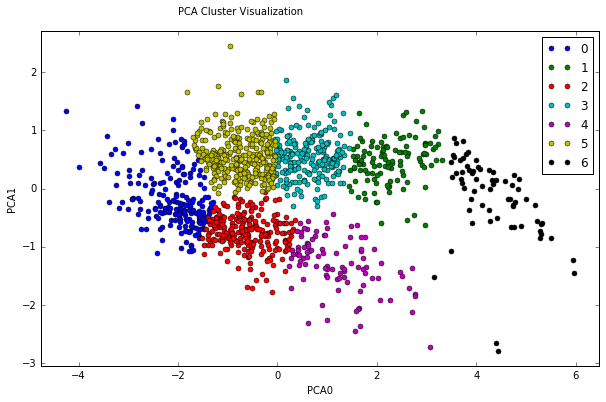

In [234]:
import matplotlib.pyplot as plt

groups = dfscale.groupby('KM_PCA_cluster')

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.PCA0, group.PCA1, marker='o', linestyle='', ms=5, label=name)
ax.legend()
ax.set_xlabel("PCA0")
ax.set_ylabel("PCA1")
ax.text(-2, 3, 'PCA Cluster Visualization')

plt.show()

In [235]:
groups

In [236]:
groups.median().sort_values(by='sat_scaled')  # bottom cluster is the low-cost group!

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster
KM_PCA_cluster,,,,,,,,,
0,-0.946604,-1.108812,-0.880801,-1.221092,-1.970898,-0.293013,-0.013264,-0.180418,0
5,-0.581526,0.130071,-0.569898,-0.499932,-0.743372,0.533931,-0.138844,0.005445,4
2,-0.143434,-0.977648,-0.113259,-0.249094,-0.632729,-0.740509,0.197218,0.046922,1
3,0.148628,0.725123,0.042193,0.399664,0.620239,0.544529,0.048637,0.076645,3
4,0.915290,-0.731850,0.746583,0.964620,0.995156,-1.283422,0.496172,0.237667,6
1,1.024813,1.390181,0.863172,1.254224,2.210701,0.493952,-0.027102,0.018691,5
6,2.448614,1.967460,2.208801,2.059757,4.261555,0.008039,-0.174083,-0.382132,2


Let's look and see how clustering with the raw data compared to clustering PCA-transformed variables.

In [237]:
groups_raw = dfscale.groupby('KM_cluster')
groups_raw.median().sort_values(by='sat_scaled') 

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_PCA_cluster
KM_cluster,,,,,,,,,
0,-0.946604,-1.133221,-0.880801,-1.232209,-1.976302,-0.307130,-0.013264,-0.183571,0
4,-0.691050,0.145050,-0.501888,-0.619080,-0.817470,0.568907,-0.268681,-0.045694,5
1,-0.143434,-0.953471,-0.171553,-0.223440,-0.656108,-0.704756,0.247949,0.054586,2
3,0.075613,0.645648,-0.093827,0.356908,0.524817,0.524762,0.106146,0.097678,3
6,0.915290,-0.731850,0.746583,0.964620,0.995156,-1.283422,0.496172,0.229759,4
5,1.043067,1.404617,0.809736,1.293845,2.210701,0.553234,0.048356,-0.007134,1
2,2.426710,1.953723,2.378826,2.028117,4.271599,-0.112206,-0.311637,-0.382471,6


The median values of the clusters are nearly the same.  Not much difference, so far.  What about visualization?  Well, the first problem is: what do we graph on each axis?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000146C74A8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000001513E668>]], dtype=object)

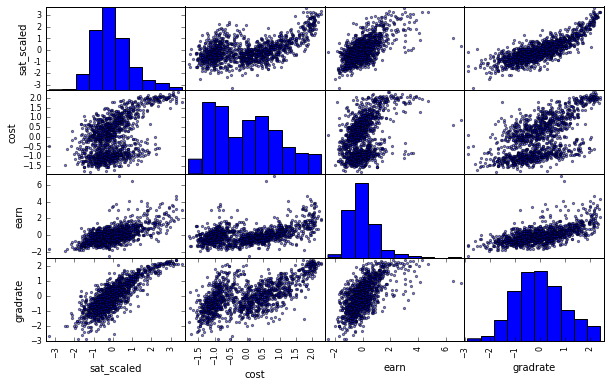

In [238]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(dfscale[['sat_scaled', 'cost', 'earn', 'gradrate']])

Let's try one that already shows distinct groups, such as cost vs. gradrate.

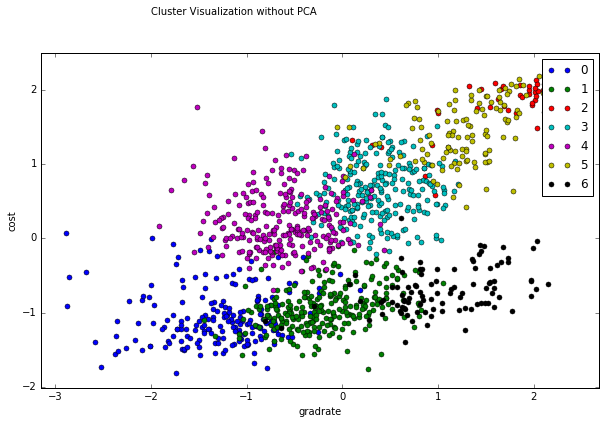

In [239]:
groups = dfscale.groupby('KM_cluster')

fig, ax = plt.subplots()
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.gradrate, group.cost, marker='o', linestyle='', ms=5, label=name)
ax.legend()
ax.set_xlabel("gradrate")
ax.set_ylabel("cost")
ax.text(-2, 3, 'Cluster Visualization without PCA')


plt.show()

Not too bad-- but still a bit of a mess compared to our PCA.  There, the clustering algorithm ran on two dimensional data.  Here, it made 4-dimensional clusters.  If you feel like you should be able peek your head around the side of the graph to get a better view of the clusters, PCA is exactly that; a transformation of variables.  It transforms in such as way as to pack as much information as possible into the first PCA variable, then the second, and so on.  That is why PCA is referred to as a "dimensionality reduction" technique.  You can also think of clustering as a dimensionality reduction technque, where we map down to one categorical dimension (cluster number).

Back to business-- my plan for a prototype product-- let's take the SAT score and align it to the nearest cluster median.  We'll return three schools from that cluster within the budget.  Then we'll take three schools from the cluster above ("reach schools") and below ("safe schools").  If we're in the top or bottom cluster to begin with, we'll return 3 additional schools from the matching cluster.  So that we can easily get the cluster above and below, let's also re-map the cluster numbers.

In [240]:
groups = dfscale.groupby('KM_PCA_cluster')
cluster_number_map = groups.median().sort_values(by='sat_scaled').index  # cluster numbers sorted from lowest to highest SAT
cluster_number_map

Int64Index([0, 5, 2, 3, 4, 1, 6], dtype='int64', name=u'KM_PCA_cluster')

In [241]:
d = { cluster_number_map[i]: i for i in range(7)}
d

{0: 0, 1: 5, 2: 2, 3: 3, 4: 4, 5: 1, 6: 6}

In [244]:
d[5]

1

In [246]:
cluster_ord = dfscale.KM_PCA_cluster.map(lambda x: d[x])
cluster_ord.head()

UNITID
100654    0
100663    2
100706    2
100724    0
100751    2
Name: KM_PCA_cluster, dtype: int64

In [247]:
cluster_ord = dfscale.KM_PCA_cluster.map(lambda x: d[x])
dfscale['cluster_ordinal'] = cluster_ord
dfscale.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster,KM_PCA_cluster,cluster_ordinal
UNITID,,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,0,0,0
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,1,2,2
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,1,2,2
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,0,0,0
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,1,2,2


Design decision: let's work with unscaled cost and SAT scores.  This way we do not have to scale incoming data.  Since we've retained the school IDs, we simply need to bring our cluster labels back to the raw dataframe.  Let's see how this would work in the notebook, then code up the prototype as a python command-line program.

In [248]:
df_joined.head()

,INSTNM,type,AvgYrCostAcademic,AvgYrCostProgram,medEarn10yrs,medEarn6yrs,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,
100654,Alabama A & M University,Public,18888.0,NaN,None,None,2013,4051.0,400.0,410.0,NaN,AL,33611.5,0.2914,810.0,31400.0
100663,University of Alabama at Birmingham,Public,19990.0,NaN,None,None,2013,11200.0,585.0,580.0,NaN,AL,23117,0.5377,1165.0,40300.0
100690,Amridge University,Private nonprofit,12300.0,NaN,None,None,2013,322.0,NaN,NaN,NaN,AL,26995,0.6667,NaN,38100.0
100706,University of Alabama in Huntsville,Public,20306.0,NaN,None,None,2013,5525.0,580.0,575.0,NaN,AL,24738,0.4835,1155.0,46600.0
100724,Alabama State University,Public,17400.0,NaN,None,None,2013,5354.0,425.0,430.0,NaN,AL,33452,0.2517,855.0,27800.0


In [249]:
dfscale.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster,KM_PCA_cluster,cluster_ordinal
UNITID,,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,0,0,0
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,1,2,2
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,1,2,2
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,0,0,0
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,1,2,2


In [251]:
df_out = pandas.concat([dfscale, df_joined], axis=1, join='inner')
df_out.head()

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster,KM_PCA_cluster,...,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,,,,,,
100654,-1.786281,-1.105436,-1.152841,-1.497584,-2.801312,0.091359,-0.293493,0.206778,0,0,...,2013,4051.0,400.0,410.0,NaN,AL,33611.5,0.2914,810.0,31400.0
100663,0.805767,-1.019907,-0.288142,-0.093461,-0.208124,-0.920128,0.791996,-0.513832,1,2,...,2013,11200.0,585.0,580.0,NaN,AL,23117,0.5377,1165.0,40300.0
100706,0.732752,-0.995382,0.323949,-0.402448,-0.111313,-1.143929,0.165254,-0.668090,1,2,...,2013,5525.0,580.0,575.0,NaN,AL,24738,0.4835,1155.0,46600.0
100724,-1.457712,-1.220923,-1.502608,-1.723908,-2.966780,0.091731,0.049002,-0.180742,0,0,...,2013,5354.0,425.0,430.0,NaN,AL,33452,0.2517,855.0,27800.0
100751,0.513705,-0.497811,-0.084111,0.640811,0.361588,-0.546345,0.687258,0.166913,1,2,...,2013,28692.0,570.0,555.0,540.0,AL,24000,0.6665,1125.0,42400.0


In [252]:
df_out.columns

Index([u'sat_scaled', u'cost', u'earn', u'gradrate', u'PCA0', u'PCA1', u'PCA2',
       u'PCA3', u'KM_cluster', u'KM_PCA_cluster', u'cluster_ordinal',
       u'INSTNM', u'type', u'AvgYrCostAcademic', u'AvgYrCostProgram',
       u'medEarn10yrs', u'medEarn6yrs', u'Year', u'NumStudents', u'Math',
       u'Verbal', u'Writing', u'State', u'DebtAtGrad', u'completionRate',
       u'sat', u'earn10'],
      dtype='object')

In [253]:
out_groups = df_out[['cluster_ordinal','sat','AvgYrCostAcademic','earn10']].groupby('cluster_ordinal')
df_cluster_lookup = out_groups.median()
df_cluster_lookup

,sat,AvgYrCostAcademic,earn10
cluster_ordinal,,,
0,925.0,18844.5,34200.0
1,975.0,34807.0,37400.0
2,1035.0,20534.5,42100.0
3,1075.0,42474.0,43700.0
4,1180.0,23701.5,50950.0
5,1195.0,51043.0,52150.0
6,1390.0,58481.0,66000.0


There is a handy pandas function for our purposes called 'argsort'.  We can use it to return the closest clusters to our query SAT score, in order.

In [259]:
query_sat = 1200
(df_cluster_lookup.sat - query_sat).abs()

cluster_ordinal
0    275.0
1    225.0
2    165.0
3    125.0
4     20.0
5      5.0
6    190.0
Name: sat, dtype: float64

In [260]:
(df_cluster_lookup.sat - query_sat).abs().argsort()

cluster_ordinal
0    5
1    4
2    3
3    2
4    6
5    1
6    0
Name: sat, dtype: int64

In [263]:

df_cluster_lookup.iloc[(df_cluster_lookup.sat - query_sat).abs().argsort()[:1]]

,sat,AvgYrCostAcademic,earn10
cluster_ordinal,,,
5,1195.0,51043.0,52150.0


I still like having ordinal labels for the clusters-- it clearly validates our argsort technique.  Now, let's get to picking out some schools, given a cluster and a budget. 

In [267]:
query_sat = 1200
query_maxcost = 45000
query_sat_add_max = 10
query_cluster = 5 # got this with argsort above

c1 = df_out['cluster_ordinal'] == query_cluster
c2 = df_out['AvgYrCostAcademic'] <= query_maxcost
c3 = df_out['sat'] <= query_sat + query_sat_add_max
condition = c1 & c2 & c3

df_out.loc[condition].sort_values(by='sat', ascending=False)[0:3]

,sat_scaled,cost,earn,gradrate,PCA0,PCA1,PCA2,PCA3,KM_cluster,KM_PCA_cluster,...,Year,NumStudents,Math,Verbal,Writing,State,DebtAtGrad,completionRate,sat,earn10
UNITID,,,,,,,,,,,,,,,,,,,,,
153269,1.024813,0.725356,1.208081,0.985713,1.977001,-0.233610,-0.209977,-0.016643,5,1,...,2013,3310.0,610.0,585.0,NaN,IA,25000,0.7270,1195.0,55700.0
170301,1.024813,0.423911,0.003330,1.295841,1.436808,0.042390,0.896860,0.196428,5,1,...,2013,3296.0,605.0,590.0,NaN,MI,27000,0.7814,1195.0,43300.0
121309,0.696244,0.770604,0.683431,0.950368,1.552051,0.124225,0.008902,0.156491,5,1,...,2013,2543.0,575.0,575.0,NaN,CA,24951,0.7208,1150.0,50300.0


Really we just need the UNITIDS

In [268]:
df_out.loc[condition].sort_values(by='sat', ascending=False)[0:3].index

Int64Index([153269, 170301, 121309], dtype='int64', name=u'UNITID')

In [271]:
picks = df_out.loc[condition].sort_values(by='sat', ascending=False)[0:3].index

df_response = df_joined.loc[picks, 
    ['INSTNM', 'type', 'NumStudents', 'AvgYrCostAcademic', 'sat', 'earn10']]
df_response

,INSTNM,type,NumStudents,AvgYrCostAcademic,sat,earn10
UNITID,,,,,,
153269,Drake University,Private nonprofit,3310.0,42477.0,1195.0,55700.0
170301,Hope College,Private nonprofit,3296.0,38593.0,1195.0,43300.0
121309,Point Loma Nazarene University,Private nonprofit,2543.0,43060.0,1150.0,50300.0


In [274]:
df_response.to_json(orient='records')

'[{"INSTNM":"Drake University","type":"Private nonprofit","NumStudents":3310.0,"AvgYrCostAcademic":42477.0,"sat":1195.0,"earn10":55700.0},{"INSTNM":"Hope College","type":"Private nonprofit","NumStudents":3296.0,"AvgYrCostAcademic":38593.0,"sat":1195.0,"earn10":43300.0},{"INSTNM":"Point Loma Nazarene University","type":"Private nonprofit","NumStudents":2543.0,"AvgYrCostAcademic":43060.0,"sat":1150.0,"earn10":50300.0}]'